In [1]:
# INTERACTIVE PLOTS (only if you code locally, unfortunately)
# This cell can take some minutes to run
# You should only need to run this cell once and not everytime you open the script
# In case the plotting of the data below does not work because of the error "Error displaying widget: model not found"
# you'll probably have to restart your kernel once more.

# IMPORTANT: After running this cell, restart your kernel
# uncomment the next two lines for interactive plots
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-leaflet
# !pip install install nodejs

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import re
import numpy as np
import pandas as pd
from scipy.signal import stft
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, multilabel_confusion_matrix
from sklearn.datasets import make_multilabel_classification
import xgboost as xgb 
import pickle
from scipy.signal import find_peaks, stft, istft
from scipy.signal import butter, lfilter
# You may change the mhealth_activity module but your algorithm must support the original version
from mhealth_activity import Recording, Trace, Activity, WatchLocation, Path



# For interactive plots, uncomment the following line
# %matplotlib widget

# TASK
### Goal:

* nr_steps (N)
* sensor_pos (0: left_writs, 1: belt, 2: right_angle)
* activities for >= 60 secs (standing: bool, walking: bool, running: bool, cycling: bool)
* path (0, 1, 2, 3, 4)

### Algo:

* nr_steps: accelerometer data use STFT
* sensor_pos (0: left_writs, 1: belt, 2: right_angle): different parts of body move in different ways. Need to identify walking first (small window 1 sec, then 10 sec and keep the ones with more than 70 walking). Then majority train on features
* activities recognition (classification): accelerometer data, 50% overlap window, on windows of around 5 seconds, mean, std, energy, correlation x 3 (X, Y, Z). Last 2 from FFT. Classification with XGBOOST per window, then aggregate the results and check if we have at least 11-12 consecutive windows of some activity. GT: phone
* path (0, 1, 2, 3, 4): not clear yet by I would say divide whole period in features over window of 5 sec. Then pass all to XGBOOST with padding and do classification. 

### INFOS

* phone_steps sometimes available but low confidence (*weak label*)
* no data where someone is draggin feet (false steps)
* activities either for < 30 seconds or >= 60 seconds
* standing: in 1 minute less than 7 steps
* walking: standing still < 8 seconds in between 2 steps is considered walking
* running: both feet above ground when running, still < 8 seconds in between 2 steps is considered running
* smartphone could be placed everywhere and varying -> data can vary a lot 
* weak label for activities in data, since only tell activity was performed, not for how long (*weak label*)

### CONSTRAINTS
* On KAGGLE CPU <= 10 seconds pred for each individual .pkl file (inference)


## TO DO
* One model for walking prediction

# Steps

In [3]:
SAMPLING_RATE = 200

In [4]:
def plot_signal(signal, title, ylabel, sampling_rate=SAMPLING_RATE, peaks=[]):
    x = np.linspace(0, len(signal) / sampling_rate, len(signal))
    t = pd.to_datetime(x, unit='s')

    fig, ax = plt.subplots()
    ax.plot(t if len(peaks) == 0 else np.linspace(0, len(signal), len(signal)) , signal)
    ax.set_title(title)
    ax.set_xlabel('Time [min:sec]' if len(peaks) == 0 else "Indexes")
    ax.set_ylabel(ylabel)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
    
    # Plot peaks if given
    if len(peaks) != 0:
        plt.plot(peaks, signal[peaks], "x", color="green")
    plt.show()

In [5]:
def get_signal_mag(ax, ay, az):

    return (ax**2 + ay**2 + az**2)**0.5

In [6]:
# Get magnitude walk
def get_signal_walk(path):
    recording = Recording(path)

    # Magnitude
    magn = get_signal_mag(recording.data['ax'].values, recording.data['ay'].values,  recording.data['az'].values)
    
    step_count = recording.labels["step_count"]
    
    return magn, step_count if step_count != None else 0


In [7]:
# Clean low frequencies, RFFT since signals contain only real values (+faster)
def algo_walk(acc_phase, label = 0, wind_length = 3.4, mov_avg_wind_s = 0.15, std_thr = 0.146, std_wind = 0.35, freq_max_hz = 2.1, prom = 2.85, sampling_rate = SAMPLING_RATE, show=False):
    # Number samples
    N = len(acc_phase)
    
    
    # Eval moving average over window
    mov_avg_wind = int(mov_avg_wind_s*sampling_rate)
    numbers_series = pd.Series(acc_phase)

    windows = numbers_series.rolling(mov_avg_wind, center=True)
    moving_averages = windows.mean()

    # Set first null entries from the list to zero
    moving_averages = moving_averages.fillna(0)
    acc_filt = moving_averages.to_numpy()

    # Plot filered signal
    if show:
        plot_signal(acc_phase[40*sampling_rate:45*sampling_rate], 'Magnitude Acc Original', 'Amplitude')
        plot_signal(acc_filt[40*sampling_rate:45*sampling_rate], 'Magnitude Acc Cleaned', 'Amplitude')

    # Get peaks every windows sec
    pred = 0

    # Walking or movement detection first
    step = int(std_wind*sampling_rate)
    moving = np.empty(N)
    for i in range(step, N - step):
        std_l = lambda val: np.std(val[int(i - step):int(i + step)]) > std_thr
        moving[i + step]  = std_l(acc_phase)
            
    # Copy for first and last
    moving[0:step] = moving[step:2*step]
    moving[-step:]= moving[-2*step:-step]
    if show:
        plot_signal(moving, "Accel Signal", "Moving")
        plot_signal(acc_phase, "Accel Signal original", "Moving")
    
    
    wind_step = int(wind_length*sampling_rate)
    for i in range(0, N, wind_step):
        acc_wind_filt = acc_filt[i:(i+ wind_step)]
        acc_wind_orig = acc_phase[i:(i+ wind_step)]
        moving_wind = moving[i:(i+ wind_step)]

        # Normalize
        # Here you can modify freely the parameters of find peak
        # Minimum distance for our peaks is len_signal_per_minute/max_acc_beat (30 seconds)
        distance = 1/freq_max_hz*sampling_rate
        prominence = (np.max(acc_wind_filt) - np.min(acc_wind_filt))/prom
        peaks, _ = find_peaks(acc_wind_filt, height = np.mean(acc_wind_filt), distance=distance, prominence=prominence)
        
        # Keeps peaks only where energy is not too low
        peaks = [peak for peak in peaks if moving_wind[peak]]
        # Find peaks with double heel, remove half
        pred += len(peaks)
        

        # Plot example in range
        if i == 8*wind_step and show:
            plot_signal(acc_wind_orig, 'Acc Orig from {} to {} s'.format(i*sampling_rate, (i+ 10)*sampling_rate), 'Amplitude', peaks=peaks)
            plot_signal(acc_wind_filt, 'Acc Filt from {} to {} s'.format(i*sampling_rate, (i+ 10)*sampling_rate), 'Amplitude', peaks=peaks)
            plot_signal(moving_wind, 'Acc wrist Filt from {} to {} s'.format(i*sampling_rate, (i+ 10)*sampling_rate), 'Amplitude', peaks=peaks)

    # Print prediction of score if given heart rate ground truth
    if label != 0:   
        print("We have found {} compared to the gt of {} steps".format(pred, label))
    return pred


In [8]:
import optuna

def objective(trial):

    wind_length = trial.suggest_float("wind_length", 0.3, 5, step=0.1)
    mov_avg_wind_s = trial.suggest_float("mov_avg_wind_s", 0.1, 2, step=0.05)
    std_thr = trial.suggest_float("std_thr", 0.001, 0.3, step=0.005)
    std_wind = trial.suggest_float("std_wind", 0.1, 1, step=0.05)
    freq_max_hz = trial.suggest_float("freq_max_hz", 1.6, 3, step=0.1)
    prom = trial.suggest_float("prom", 1, 3, step=0.05)
    path = "data/train/train_trace_0"
    suffix = ".pkl"

    loss = 0
    for i in range(10, 45, 1):
        path_act = path + str(i) + suffix
        sign, label = get_signal_walk(path_act)
        if label == 0:
            continue
        nr_step = algo_walk(sign, 0, wind_length, mov_avg_wind_s, std_thr, std_wind, freq_max_hz, prom, show=False)
        loss += (nr_step - label)**2

    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=60)
print('Best hyperparameters:', study.best_params)
print('Best Acc score:', study.best_value)

[I 2024-05-01 20:49:07,380] Trial 60 finished with value: 285823.0 and parameters: {'wind_length': 2.4, 'mov_avg_wind_s': 1.05, 'std_thr': 0.041, 'std_wind': 0.9500000000000001, 'freq_max_hz': 1.8, 'prom': 2.95}. Best is trial 34 with value: 57245.0.
[I 2024-05-01 20:49:22,294] Trial 61 finished with value: 74351.0 and parameters: {'wind_length': 3.1, 'mov_avg_wind_s': 1.35, 'std_thr': 0.116, 'std_wind': 0.75, 'freq_max_hz': 2.0, 'prom': 2.5}. Best is trial 34 with value: 57245.0.
[I 2024-05-01 20:49:37,709] Trial 62 finished with value: 79292.0 and parameters: {'wind_length': 2.9, 'mov_avg_wind_s': 1.3000000000000003, 'std_thr': 0.116, 'std_wind': 0.7000000000000001, 'freq_max_hz': 2.0, 'prom': 2.55}. Best is trial 34 with value: 57245.0.
[I 2024-05-01 20:49:51,312] Trial 63 finished with value: 137776.0 and parameters: {'wind_length': 3.5, 'mov_avg_wind_s': 1.4500000000000002, 'std_thr': 0.191, 'std_wind': 0.8, 'freq_max_hz': 2.2, 'prom': 2.75}. Best is trial 34 with value: 57245.0.


Best hyperparameters: {'wind_length': 3.4, 'mov_avg_wind_s': 0.15000000000000002, 'std_thr': 0.146, 'std_wind': 0.35, 'freq_max_hz': 2.1, 'prom': 2.85}
Best Acc score: 51112.0


In [62]:
print('Best Acc score:', study.best_params)

Best Acc score: {'wind_length': 1.0, 'mov_avg_wind_s': 1.3000000000000003, 'std_thr': 0.006, 'std_wind': 0.55, 'prom': 2.8}


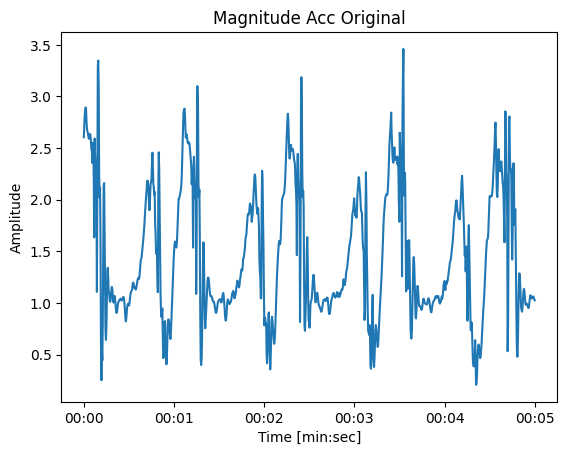

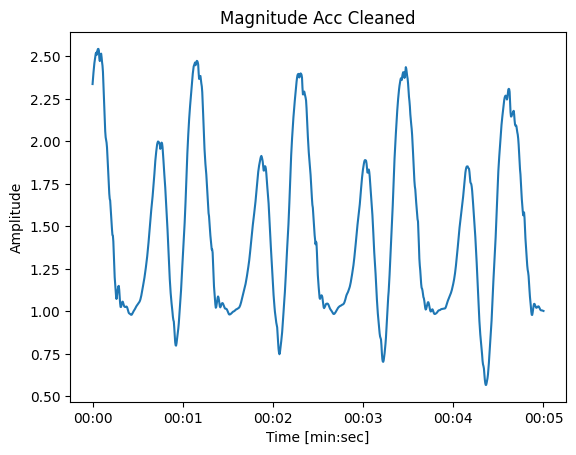

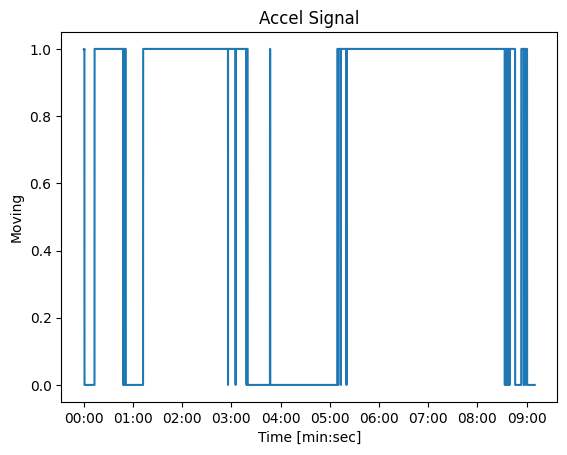

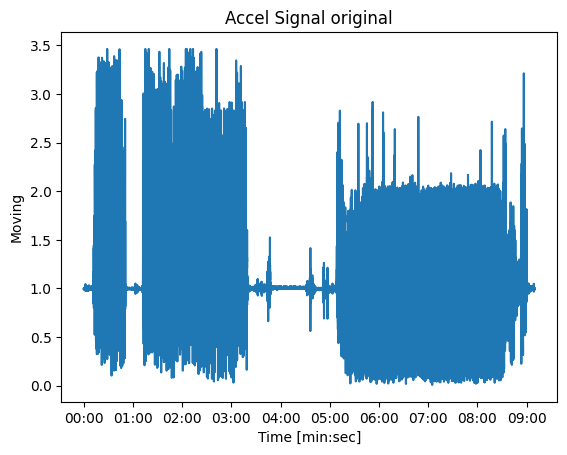

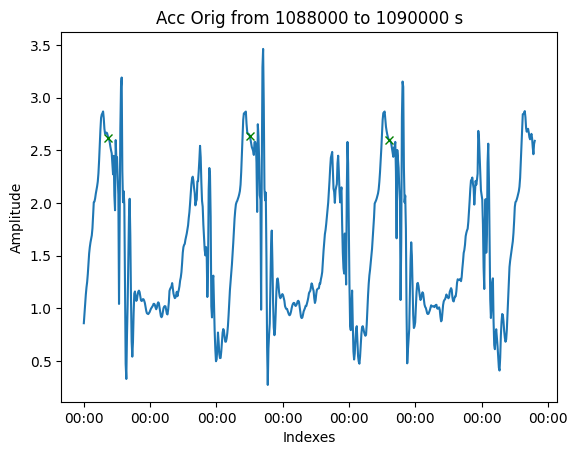

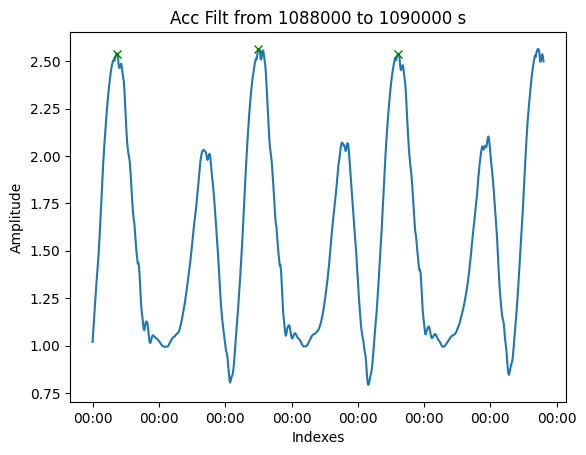

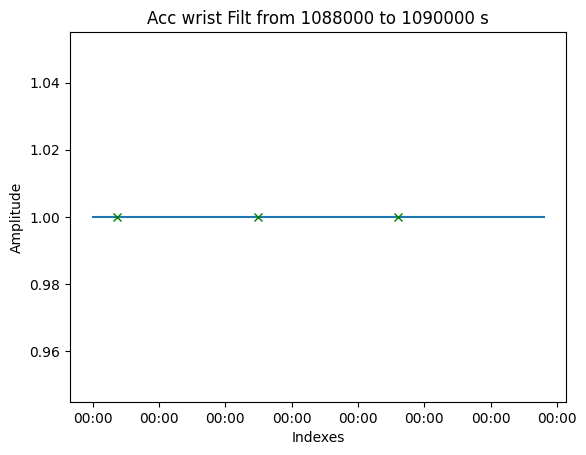

We have found 352 compared to the gt of 288 steps


352

In [15]:
path = "data/train/train_trace_014.pkl"


sign, label = get_signal_walk(path)
plot_window_start = 200*SAMPLING_RATE  # in seconds
plot_window_end = 205*SAMPLING_RATE  # in seconds

algo_walk(sign, label, show=True)

# Other Tasks

In [16]:
# Extend length of a sensor with lower sample rate to a higher by copying values
def extend_length_sensor(recording, sensor):
    sensor_ext = np.empty(recording.data["ax"].timestamps.shape)
    c = 0
    for id, time in enumerate(recording.data["ax"].timestamps):
        if recording.data[sensor].timestamps[c] < time:
            c += 1
        sensor_ext[id] = recording.data[sensor].values[c]
    return sensor_ext

In [17]:
# Main processing functions

In [18]:
SENSOR_DIFF_SAMPLE_RATE = ["mx", "my", "mz", "altitude"]
MEASURES = ["mean", "std", "energy", "max_freq"]

In [19]:
def get_data_sample(path, wind_length_s, wind_overlap_per, sensors_corr = ["ax", "ay", "az", "gx", "gy", "gz", "mx", "my", "mz", "altitude"], sensors_no_corr = [], labels=True, extend_ffill=True):
    # checking if it is a file
    assert os.path.isfile(path), "path not valid"

    # Read file
    recording = Recording(path)

    # Define variables
    sensors = sensors_corr + sensors_no_corr 
    corr = [x + "_" + y +"_" + "corr" for i, x in enumerate(sensors_corr) for y in sensors_corr[(i+1):]]
    features = [sens + "_" + meas for sens in sensors for meas in MEASURES] 
    columns = (["Sample"] + ["Steps", "Frequency", "Length", "Timestamps", "StepsWindow"] + features + corr)

    # Get frequency of sampling
    frequency = recording.data[sensors[0]].samplerate
    wind_nr_sample = int(frequency*wind_length_s)
    wind_step = int(wind_nr_sample*wind_overlap_per)
    # Get all the sensor data we want in windows
    data_rec = pd.DataFrame(columns=columns)

    # Add all sensors measures
    for sensor in sensors:
        # Extend sensors with diff sample rate
        if sensor in SENSOR_DIFF_SAMPLE_RATE:
            recording.data[sensor].values = extend_length_sensor(recording, sensor)

        # Read data as pd
        data_val = pd.DataFrame(recording.data[sensor].values)
        # Fill last values up to divisible size
        nr_miss = wind_step - len(data_val)%wind_step

        # Extend with given idea to divisible length
        if extend_ffill:
            row_pad = data_val.iloc[[-1]*nr_miss]
        else:
            row_pad = pd.DataFrame(0, index=np.arange(nr_miss), columns=data_val.columns) 
        
        data_val = pd.concat([data_val, row_pad], ignore_index=True)
        
        # Evaluate mean and std
        data_rec[sensor + "_mean"] =  data_val.rolling(window = wind_nr_sample,
        min_periods = wind_nr_sample, step = wind_step, center=True).mean()[1:]
        data_rec[sensor + "_std"] = data_val.rolling(window = wind_nr_sample,
        min_periods = wind_nr_sample, step=wind_step, center=True).std()[1:]
        # Evaluate stfft and skip first and last index since window is placed centered on first and last value
        f, t, Zxx = stft(data_val.to_numpy().squeeze(axis=1), fs=frequency, nperseg = wind_nr_sample, noverlap= wind_nr_sample - wind_step)
        Zxx = np.transpose(Zxx)[1:-1]
        energy = np.sum(np.abs(Zxx)**2, axis = 1)/wind_length_s
        data_rec[sensor + "_energy"]  = energy

        get_freq = lambda x: f[x]
        data_rec[sensor + "_max_freq"] = get_freq(np.argmax(Zxx, axis = 1))
    
    # Add nr_steps per window
    sign_mag = get_signal_mag(recording.data["ax"].values, recording.data["ay"].values, recording.data["az"].values)
    steps_per_window = np.empty(len(data_rec))
    for id, i in enumerate(range(wind_step, len(sign_mag) - wind_step, wind_step)):
        steps_per_window[id] = algo_walk(sign_mag[i-wind_step:i+wind_step])

    data_rec["StepsWindow"] = steps_per_window

    # Put constant values
    data_rec["Steps"] = algo_walk(sign_mag)

    data_rec["Sample"] = path 
    data_rec["Frequency"] = recording.data[sensors[0]].samplerate
    data_rec["Length"] = recording.data[sensors[0]].total_time
    data_rec["Timestamps"] = np.arange(0, len(data_rec), 1)/200
    
    if labels:
        # Add activity
        for activity in Activity:
            data_rec[activity.name] = 1*(activity.value in recording.labels["activities"])

        # Add path loc
        data_rec["path_idx"] = recording.labels["path_idx"]
        
        # Add watch loc
        data_rec["watch_loc"] = recording.labels["watch_loc"]


    # Reset indexes
    data_rec.reset_index(drop=True, inplace=True)

    # Add correlations between requested sensors
    for i, sens_x in enumerate(sensors_corr):
        sens_x_val = recording.data[sens_x].values
        for sens_y in sensors_corr[(i+1):]:
            pd_corr = pd.DataFrame(np.transpose(np.vstack((sens_x_val, recording.data[sens_y].values))))
            nr_miss = wind_step - len(pd_corr)%wind_step
            # Get perfect length divisiblity by wind_length
            if extend_ffill:
                row_pad = pd_corr.iloc[[-1]*nr_miss]
            else:
                row_pad = pd.DataFrame(0, index=np.arange(nr_miss), columns=pd_corr.columns)
            pd_corr = pd.concat([pd_corr, row_pad], ignore_index=True)
            
            # Need optimize but rolling no support for corr yet
            for id, i in enumerate(range(0, len(pd_corr) - wind_step, wind_step)):
                corr_matrix = pd_corr[i:i + wind_nr_sample].corr()  
                data_rec.at[id, sens_x + "_" + sens_y +"_" + "corr" ] = corr_matrix.iloc[0, 1]
    
    # Fill Na values of last row per sample
    data_rec = data_rec.fillna(method='ffill')
    data_rec = data_rec.fillna(method='bfill')
    
    return data_rec
                

In [20]:
# Get data accel with corresponding label from all the path as df
def get_data(path, wind_length_s = 200, wind_overlap_per = 1, sensors_corr = ["ax", "ay", "az", "gx", "gy", "gz", "mx", "my", "mz", "altitude"], sensors_no_corr = [], labels=True, extend_ffill = True):
    
    data = pd.DataFrame()
    for idx, filename in enumerate(os.listdir(path)):
        f = os.path.join(path, filename)
        
        # Get data per sample
        data_rec = get_data_sample(f, wind_length_s, wind_overlap_per, sensors_corr, sensors_no_corr, labels, extend_ffill)
        
        # Init data if first file
        if idx == 0:
            data = data_rec
            continue
        # Concatenate two dataframes
        data = pd.concat([data, data_rec], ignore_index=True)
        if idx % 10 == 9:
            print("Processed {} examples".format(idx))
    
    return data    


In [21]:
# Get features per sample across windows
def features_per_sample(df):
    mean = df.groupby('Sample').mean()
    mean = mean.add_prefix("mean_")
    std = df.groupby('Sample').std()
    std = std.add_prefix("std_")

    max = df.groupby('Sample').max()
    max = max.add_prefix("max_")

    min = df.groupby('Sample').min()
    min = min.add_prefix("min_")

    median = df.groupby('Sample').median()
    median = median.add_prefix("median_")

    quantile25 = df.groupby('Sample').quantile(q=0.25)
    quantile25 = quantile25.add_prefix("q25_")

    quantile75 = df.groupby('Sample').quantile(q=0.75)
    quantile75 = quantile75.add_prefix("q75_")
    
    df_final =  pd.concat([mean, std, max, min, median, quantile25, quantile75], axis = 1)
    return df_final

In [22]:
def F1_score_conf_matrix(conf_matrix):
    F1_per_class = np.empty(len(conf_matrix))
    for i, matrix in enumerate(conf_matrix):
        F1_per_class[i] = (2*matrix[1][1])/(2*matrix[1][1] + matrix[0][1] + matrix[1][0])
    return F1_per_class

def bal_acc_score_conf_matrix(conf_matrix):
    bal_ac_per_class = np.empty(len(conf_matrix))
    for i, matrix in enumerate(conf_matrix):
        bal_ac_per_class[i] = ((matrix[1][1])/(matrix[1][1] + matrix[1][0]) + (matrix[0][0])/(matrix[0][0] + matrix[0][1]))/2
    return bal_ac_per_class

# Watch Loc

In [23]:
path = "data/train/"
df = get_data(path, wind_length_s = 60, wind_overlap_per = 0.5)

Processed 9 examples
Processed 19 examples
Processed 29 examples
Processed 39 examples
Processed 49 examples


In [ ]:
df.to_csv("final_steps.csv", index=False)

In [16]:
# Get labels
labels = df.groupby('Sample').max()[["watch_loc"]]
steps = df.groupby('Sample').max()[["Steps"]]

In [17]:
df_filt = df.drop(["Frequency", "path_idx", "Steps", "watch_loc", "Length", "STANDING", "Timestamps", "WALKING",	"RUNNING",	"CYCLING"], axis=1)

In [18]:
df_features_samples = features_per_sample(df_filt)
df_final =  pd.concat([df_features_samples, labels[['watch_loc']], steps[["Steps"]]], axis=1)

In [19]:
train, test = train_test_split(df_final, test_size=0.2, shuffle=False)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

X_train = train.drop(['watch_loc'], axis =1)
y_train = train[['watch_loc']]
X_test = test.drop(['watch_loc'], axis =1)
y_test = test[['watch_loc']]

In [20]:
import optuna

def objective(trial):
    params = {
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_test)
    conf_matrix = multilabel_confusion_matrix(predictions, y_test)

    acc_score = np.mean(bal_acc_score_conf_matrix(conf_matrix))
    return acc_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print('Best hyperparameters:', study.best_params)
print('Best Acc score:', study.best_value)

[I 2024-05-01 16:07:32,861] A new study created in memory with name: no-name-319afdd6-0878-4e11-8916-9e970c7726a7


[I 2024-05-01 16:07:40,718] Trial 0 finished with value: 0.9803030303030303 and parameters: {'learning_rate': 0.0024973217741475354, 'max_depth': 6, 'subsample': 0.8355598443095398, 'colsample_bytree': 0.4978690006346865, 'min_child_weight': 19}. Best is trial 0 with value: 0.9803030303030303.
[I 2024-05-01 16:07:49,432] Trial 1 finished with value: 0.9803030303030303 and parameters: {'learning_rate': 0.007244732367055432, 'max_depth': 4, 'subsample': 0.9091865685372678, 'colsample_bytree': 0.7973919766185044, 'min_child_weight': 9}. Best is trial 0 with value: 0.9803030303030303.
[I 2024-05-01 16:07:52,806] Trial 2 finished with value: 0.9803030303030303 and parameters: {'learning_rate': 0.06545002005635475, 'max_depth': 4, 'subsample': 0.6625362817791655, 'colsample_bytree': 0.8112794446767367, 'min_child_weight': 8}. Best is trial 0 with value: 0.9803030303030303.
[I 2024-05-01 16:07:56,779] Trial 3 finished with value: 0.9897222222222223 and parameters: {'learning_rate': 0.01057302

Best hyperparameters: {'learning_rate': 0.010573027126498732, 'max_depth': 7, 'subsample': 0.631782776849384, 'colsample_bytree': 0.8331493477162181, 'min_child_weight': 20}
Best Acc score: 0.9897222222222223


In [58]:
clf_watch = xgb.XGBClassifier(n_estimators=1000)
clf_watch.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

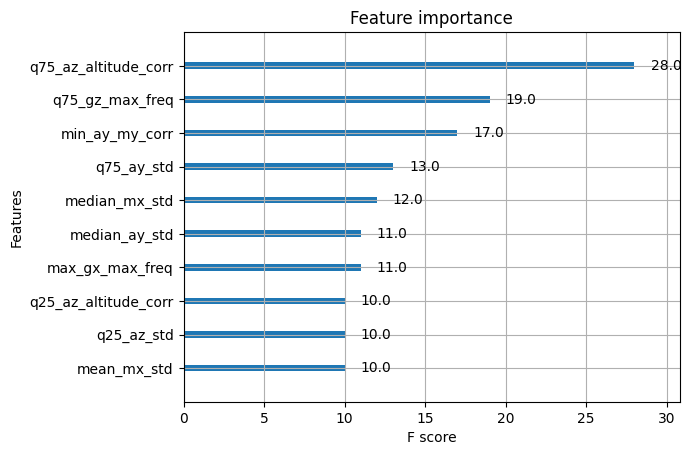

In [59]:
import xgboost as xgb 
xgb.plot_importance(clf_watch, max_num_features=10)

In [61]:
pred = clf_watch.predict(X_test)

conf_matrix = multilabel_confusion_matrix(pred, y_test)

print(F1_score_conf_matrix(conf_matrix))
print(bal_acc_score_conf_matrix(conf_matrix))


[0.96153846 0.93617021 0.98360656]
[0.97150997 0.94940476 0.99      ]


In [27]:
pred

array([0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 0, 2, 0, 1, 1,
       0, 2, 1, 2, 0, 1, 0, 2, 2, 2, 1, 0, 1, 2, 0, 2, 0, 2, 0, 1, 1, 0,
       1, 0, 2, 1, 0, 2, 2, 2, 1, 2, 1, 2, 2, 0, 0, 2, 2, 1, 1, 2, 2, 0,
       2, 2, 1, 1, 2, 2, 1, 0, 2, 2, 0, 1, 0, 1])

In [132]:
file_name = "clf_watch.pkl"

# save
pickle.dump("clf_watch.pkl", open(file_name, "wb"))

# Path Finding

In [35]:
path = "data/train/"
df = get_data(path, wind_length_s = 60, sensors_corr = ["gx", "gy", "gz", "mx", "my", "mz", "altitude"], sensors_no_corr = ["ax", "ay", "az"], wind_overlap_per = 0.5)

Processed 9 examples
Processed 19 examples
Processed 29 examples
Processed 39 examples
Processed 49 examples
Processed 59 examples
Processed 69 examples
Processed 79 examples
Processed 89 examples
Processed 99 examples
Processed 109 examples
Processed 119 examples
Processed 129 examples
Processed 139 examples
Processed 149 examples
Processed 159 examples
Processed 169 examples
Processed 179 examples
Processed 189 examples
Processed 199 examples
Processed 209 examples
Processed 219 examples
Processed 229 examples
Processed 239 examples
Processed 249 examples
Processed 259 examples
Processed 269 examples
Processed 279 examples
Processed 289 examples
Processed 299 examples
Processed 309 examples
Processed 319 examples
Processed 329 examples
Processed 339 examples
Processed 349 examples
Processed 359 examples
Processed 369 examples
Processed 379 examples
Processed 389 examples


In [33]:
# Get labels
labels = df.groupby('Sample').max()[["path_idx"]]
steps = df.groupby('Sample').max()[["Steps"]]

In [34]:
df_filt = df.drop(["Frequency", "path_idx", "watch_loc", "Steps", "Length", "STANDING", "Timestamps", "WALKING",	"RUNNING",	"CYCLING"], axis=1)

In [35]:
df_features_samples = features_per_sample(df_filt)
df_final =  pd.concat([df_features_samples, labels[['path_idx']], steps[["Steps"]]], axis=1)

In [36]:
train, test = train_test_split(df_final, test_size=0.2, shuffle=False)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

X_train = train.drop(['path_idx'], axis =1)
y_train = train[['path_idx']]
X_test = test.drop(['path_idx'], axis =1)
y_test = test[['path_idx']]

In [38]:
import optuna

def objective(trial):
    params = {
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_test)
    conf_matrix = multilabel_confusion_matrix(predictions, y_test)

    acc_score = np.mean(bal_acc_score_conf_matrix(conf_matrix))
    return acc_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-05-01 18:56:31,807] Trial 30 finished with value: 0.7078545464184839 and parameters: {'learning_rate': 0.024375752078082367, 'max_depth': 3, 'subsample': 0.8877770979744075, 'colsample_bytree': 0.1373420317292668, 'min_child_weight': 16}. Best is trial 9 with value: 0.7445589443490708.
[I 2024-05-01 18:56:41,356] Trial 31 finished with value: 0.6995622669061744 and parameters: {'learning_rate': 0.011513638213901743, 'max_depth': 6, 'subsample': 0.7303275262442787, 'colsample_bytree': 0.21956707040349666, 'min_child_weight': 16}. Best is trial 9 with value: 0.7445589443490708.
[I 2024-05-01 18:56:51,331] Trial 32 finished with value: 0.7004415584415584 and parameters: {'learning_rate': 0.012488109333454895, 'max_depth': 7, 'subsample': 0.31805884947817464, 'colsample_bytree': 0.5644765222659758, 'min_child_weight': 7}. Best is trial 9 with value: 0.7445589443490708.
[I 2024-05-01 18:56:56,058] Trial 33 finished with value: 0.7561803462865383 and parameters: {'learning_rate': 0.0

Best hyperparameters: {'learning_rate': 0.042504200621122076, 'max_depth': 5, 'subsample': 0.3981140665749457, 'colsample_bytree': 0.19323995485714823, 'min_child_weight': 5}
Best RMSE: 0.7829152542372882


In [ ]:
Best hyperparameters: {'learning_rate': 0.042504200621122076, 'max_depth': 5, 'subsample': 0.3981140665749457, 'colsample_bytree': 0.19323995485714823, 'min_child_weight': 5}

In [66]:
clf_path = xgb.XGBClassifier(n_estimators=1000)
clf_path.fit(X_train, y_train.values)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

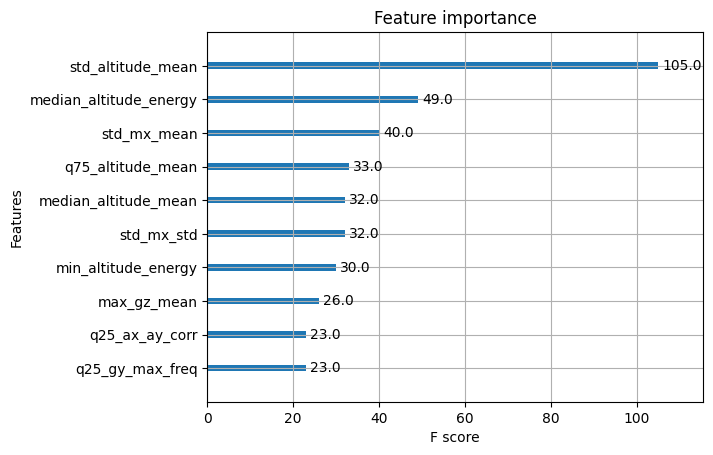

In [67]:
import xgboost as xgb 
xgb.plot_importance(clf_path, max_num_features=10)

In [68]:
pred = clf_path.predict(X_test)

conf_matrix = multilabel_confusion_matrix(pred, y_test.values)

print(F1_score_conf_matrix(conf_matrix))
print(bal_acc_score_conf_matrix(conf_matrix))

[0.5        0.4        0.33333333 0.46153846 0.82926829]
[0.66343826 0.72407045 0.61660079 0.63557994 0.90638481]


In [229]:
pred

array([4, 0, 2, 0, 0, 1, 3, 3, 4, 1, 4, 1, 3, 0, 3, 1, 0, 0, 2, 2, 2, 4,
       3, 4, 4, 4, 1, 3, 4, 0, 4, 2, 0, 4, 3, 4, 3, 3, 2, 0, 0, 3, 3, 1,
       3, 4, 4, 4, 4, 2, 4, 2, 3, 4, 3, 3, 2, 4, 0, 4, 0, 0, 0, 0, 1, 0,
       3, 0, 0, 3, 0, 0, 4, 2, 4, 1, 4, 1, 4, 0])

In [149]:
file_name = "clf_path.pkl"

# save
pickle.dump("clf_path.pkl", open(file_name, "wb"))

# Activity recognition

Activities recognition (classification): accelerometer, gyroscope data, 50% overlap window, on windows of around 60 seconds. Classification with XGBOOST after aggregating features
* Most are kind of same length

In [21]:
path = "data/train/"
df = get_data(path, wind_length_s = 60, wind_overlap_per = 0.5)
steps = df.groupby('Sample').max()[["Steps"]]

Processed 9 examples
Processed 19 examples
Processed 29 examples
Processed 39 examples
Processed 49 examples
Processed 59 examples
Processed 69 examples
Processed 79 examples
Processed 89 examples
Processed 99 examples
Processed 109 examples
Processed 119 examples
Processed 129 examples
Processed 139 examples
Processed 149 examples
Processed 159 examples
Processed 169 examples
Processed 179 examples
Processed 189 examples
Processed 199 examples
Processed 209 examples
Processed 219 examples
Processed 229 examples
Processed 239 examples
Processed 249 examples
Processed 259 examples
Processed 269 examples
Processed 279 examples
Processed 289 examples
Processed 299 examples
Processed 309 examples
Processed 319 examples
Processed 329 examples
Processed 339 examples
Processed 349 examples
Processed 359 examples
Processed 369 examples
Processed 379 examples
Processed 389 examples


In [26]:
# Get labels
labels = df.groupby('Sample').sum()[["STANDING", "WALKING",	"RUNNING",	"CYCLING"]]
labels[labels >= 1] = 1

In [27]:
# Drop not used features
df_filt = df.drop(["Frequency", "path_idx", "watch_loc", "Steps", "Length", "STANDING", "Timestamps",	"WALKING",	"RUNNING",	"CYCLING"], axis=1)

In [28]:
df_features_samples = features_per_sample(df_filt)

In [29]:
df_final =  pd.concat([df_features_samples, labels[['STANDING', 'WALKING', 'RUNNING', 'CYCLING']], steps[["Steps"]]], axis=1)

In [30]:
train, test = train_test_split(df_final, test_size=0.2, shuffle=False)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

X_train = train.drop(['STANDING', 'WALKING', 'RUNNING', 'CYCLING'], axis =1)
y_train = train[['STANDING', 'WALKING', 'RUNNING', 'CYCLING']]
X_test = test.drop(['STANDING', 'WALKING', 'RUNNING', 'CYCLING'], axis =1)
y_test = test[['STANDING', 'WALKING', 'RUNNING', 'CYCLING']]

In [31]:
import optuna

def objective(trial):
    params = {
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_test)
    conf_matrix = multilabel_confusion_matrix(predictions, y_test)

    acc_score = np.mean(bal_acc_score_conf_matrix(conf_matrix))
    return acc_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-05-01 16:13:18,002] A new study created in memory with name: no-name-be5b1714-2e5f-4e1d-a2f9-099511a16ec8
/tmp/ipykernel_162006/1634723069.py:10: RuntimeWarning: invalid value encountered in scalar divide
  bal_ac_per_class[i] = ((matrix[1][1])/(matrix[1][1] + matrix[1][0]) + (matrix[0][0])/(matrix[0][0] + matrix[0][1]))/2
[W 2024-05-01 16:13:22,163] Trial 0 failed with parameters: {'learning_rate': 0.0011756867772130214, 'max_depth': 10, 'subsample': 0.10091607094206562, 'colsample_bytree': 0.1570073618375117, 'min_child_weight': 11} because of the following error: The value nan is not acceptable.
[W 2024-05-01 16:13:22,163] Trial 0 failed with value nan.
/tmp/ipykernel_162006/1634723069.py:10: RuntimeWarning: invalid value encountered in scalar divide
  bal_ac_per_class[i] = ((matrix[1][1])/(matrix[1][1] + matrix[1][0]) + (matrix[0][0])/(matrix[0][0] + matrix[0][1]))/2
[W 2024-05-01 16:13:25,834] Trial 1 failed with parameters: {'learning_rate': 0.009360998924042617, 'max_dep

Best hyperparameters: {'learning_rate': 0.04150589953711549, 'max_depth': 2, 'subsample': 0.8845487856365819, 'colsample_bytree': 0.7264307517298395, 'min_child_weight': 1}
Best RMSE: 0.9819922411380625


In [48]:
clf_activ = xgb.XGBClassifier(n_estimators=1000)
clf_activ.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

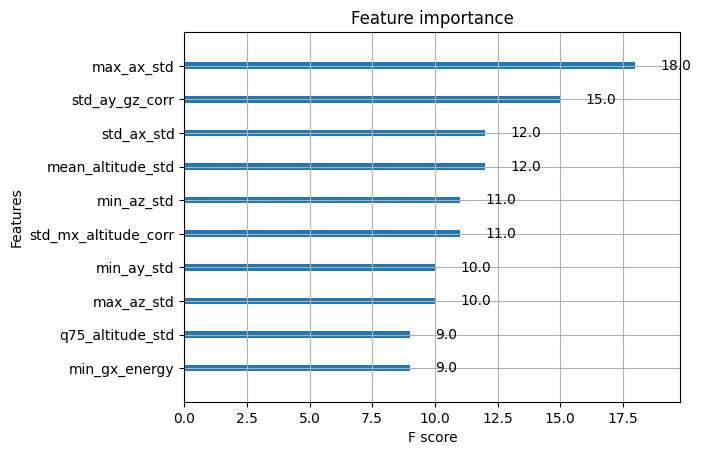

In [49]:
import xgboost as xgb 
xgb.plot_importance(clf_activ, max_num_features=10)

In [38]:
import pickle
clf_activ = pickle.load(open("clf_activ.pkl", "rb"))

In [51]:
# Test
pred = clf_activ.predict(X_test)

conf_matrix = multilabel_confusion_matrix(pred, y_test)

print(pred)
print(F1_score_conf_matrix(conf_matrix))
print(bal_acc_score_conf_matrix(conf_matrix))

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 1. 0. 1.]
 [1. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 0. 1.]
 [0. 1. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 1. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 1. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 1. 1. 0.]
 [0. 1. 0. 0.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]
 [0. 1. 0. 0.]
 [1. 1. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 1. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 1. 0.]
 [1. 1. 0. 0.]
 [0. 1. 0. 1.]
 [0. 1. 1.

/tmp/ipykernel_157315/1634723069.py:10: RuntimeWarning: invalid value encountered in scalar divide
  bal_ac_per_class[i] = ((matrix[1][1])/(matrix[1][1] + matrix[1][0]) + (matrix[0][0])/(matrix[0][0] + matrix[0][1]))/2


In [52]:
pred

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 1., 0.],
       [0., 1., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 1., 0., 0.],
       [0., 1., 0., 1.],
       [1., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 1., 0.],
       [0., 1., 0., 1.],
       [0., 1., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],


In [148]:
file_name = "clf_activ.pkl"

# save
pickle.dump("clf_activ.pkl", open(file_name, "wb"))

# FYI: How Timestamps Are Handled (You Probably Don't Need This)

Every time the smartphone receives a package via Bluetooth from the LilyGo smartwatch, up to 16 sensor values are stored at once, together with the current timestamp. Therefore, not every sensor reading has a perfectly defined timestamp that is 100% accurate.

Each <code>Trace</code> contains a list of <code>raw_timestamps</code>, which are tuples of the type `(trace index, timestamp)`.

The timestamps are standard Unix timestamps in milliseconds.

For example, the first two entries indicate "The 0th value arrived at 1645184293057, the 16th value at 1645184293144."

In [ ]:
recording.data["ax"].raw_timestamps

In [ ]:
recording.data['ax'].raw_timestamps[-1][1]-recording.data['ax'].raw_timestamps[0][1]

The LilyGo uses a FIFO with a constant sampling rate, so it should be a fair assumption, that the delay between two consecutive readings is always the same.

By default the <code>Trace.timestamps</code> array is linearly interpolated between the first and the last timestamp (<code>linspace(0, last_timestamp, num=len(values))</code>)

In [ ]:
# Compare "ideal" interpolated timestamps against actual received timestamps
recording.data['ideal_ts'] = Trace('ideal_ts', 
                                   [recording.data['timestamp'].values[0], recording.data['timestamp'].values[-1]], 
                                   [(0,recording.data['timestamp'].values[0]), 
                                    (len(recording.data['timestamp'].values), recording.data['timestamp'].values[-1])])
recording.plot(['timestamp', 'ideal_ts'], labels=['Received timestamps', 'Interpolated Timestamps'], ylabels=['ms'])